In [1]:
import pandas as pd
import hvplot.pandas
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy.stats as st
import seaborn as sns
cm=sns.light_palette("green", as_cmap=True)
cm1=sns.light_palette("blue", as_cmap=True)
cm2=sns.light_palette("purple", as_cmap=True)
cm3=sns.light_palette("orange", as_cmap=True)
cm4=sns.light_palette("yellow", as_cmap=True)
from warnings import filterwarnings
filterwarnings("ignore")
from config import census_api_key
from config import geoapify_key


In [2]:
population_county_pd = pd.read_csv("Resources/population_county.csv")
population_county_pd['County'] = population_county_pd['County'].str.replace('.', '')
population_county_pd['2020'] = population_county_pd['2020'].str.replace(',', '')
population_county_pd['2021'] = population_county_pd['2021'].str.replace(',', '')
population_county_pd['2022'] = population_county_pd['2022'].str.replace(',', '')
population_county_pd['2023'] = population_county_pd['2023'].str.replace(',', '')
population_county_pd.head()

,County,2020,2021,2022,2023
0,"Autauga County, Alabama",58915,59203,59726,60342
1,"Baldwin County, Alabama",233227,239439,246531,253507
2,"Barbour County, Alabama",24969,24533,24700,24585
3,"Bibb County, Alabama",22188,22359,21986,21868
4,"Blount County, Alabama",59107,59079,59516,59816


## -----------------------------------------------------------------------------------------------------------------------------
## Finding Counties with Highest Population Growth by Number

In [3]:

population_county_pd['2020']=population_county_pd['2020'].astype(int)
population_county_pd['2021']=population_county_pd['2021'].astype(int)
population_county_pd['2022']=population_county_pd['2022'].astype(int)
population_county_pd['2023']=population_county_pd['2023'].astype(int)

In [4]:
pop_growth_percent = population_county_pd.copy()

In [5]:
population_county_pd['Pop Growth from 2020-2023']=population_county_pd['2023']-population_county_pd['2020']

In [6]:
pop_growth_pd = population_county_pd[['County', '2020', '2023', 'Pop Growth from 2020-2023']].copy()

In [7]:
pop_growth_sorted = pop_growth_pd.sort_values('Pop Growth from 2020-2023', ascending=False)

pop_growth_100 = pop_growth_sorted.iloc[0:100].copy()

In [8]:
pop_100 = pop_growth_100.set_index('County')

In [9]:
counties = []
lat = []
lon = []
for row in pop_100.iterrows():
    counties.append(row[0])

In [10]:
print(f'--------------------------------------------------')
print(f'Downloading Latitude and Longitude for each county')
for county in counties:
    target_county = county
    target_url = f"https://api.geoapify.com/v1/geocode/search?text={target_county}&format=json&apiKey={geoapify_key}"
    response = requests.get(target_url).json()
    lat.append(response["results"][0]["lat"])
    lon.append(response["results"][0]["lon"])
    print(f'Found Latitude and Longitude for {target_county}.')
    
print('Finished searching for Latitude and Longitudes')
print(f'--------------------------------------------------')


--------------------------------------------------
Found Latitude and Longitude for Maricopa County, Arizona.
Found Latitude and Longitude for Collin County, Texas.
Found Latitude and Longitude for Harris County, Texas.
Found Latitude and Longitude for Denton County, Texas.
Found Latitude and Longitude for Polk County, Florida.
Found Latitude and Longitude for Fort Bend County, Texas.
Found Latitude and Longitude for Montgomery County, Texas.
Found Latitude and Longitude for Williamson County, Texas.
Found Latitude and Longitude for Bexar County, Texas.
Found Latitude and Longitude for Riverside County, California.
Found Latitude and Longitude for Hillsborough County, Florida.
Found Latitude and Longitude for Lee County, Florida.
Found Latitude and Longitude for Tarrant County, Texas.
Found Latitude and Longitude for Pasco County, Florida.
Found Latitude and Longitude for Clark County, Nevada.
Found Latitude and Longitude for Wake County, North Carolina.
Found Latitude and Longitude fo

In [11]:
pop_100['Latitude']=lat
pop_100['Longitude']=lon

In [12]:
pop_100.to_csv('Resources/PopulationGrowthTop100.csv')

In [13]:
# Obtained Median Income for Top 100 Counties by Population Growth from: https://www.census.gov/quickfacts/

top100_median_df = pd.read_csv("Resources/Top100Medianincome.csv")


In [14]:
pop_100median = pop_100.merge(top100_median_df, on='County')
pop_100median['Pop Growth % from 2020-2023'] = pop_100median['2023']/pop_100median['2020']*100-100
pop_100median = pop_100median[['County', 'Pop Growth from 2020-2023', 'Pop Growth % from 2020-2023', 'Median Income', 'Latitude', 'Longitude']]
pop_100display = pop_100median.set_index('County').copy()
pop_100display
pop_100display.style.background_gradient(subset=['Pop Growth from 2020-2023'], 
                                             cmap=cm2).background_gradient(subset=['Pop Growth % from 2020-2023'], 
                                             cmap=cm1).background_gradient(subset=['Median Income'], cmap=cm).format({
    'Median Income':"${:,.0f}", 'Pop Growth from 2020-2023':"{:,.0f}", 'Pop Growth % from 2020-2023':"{:,.2f}%"})


,Pop Growth from 2020-2023,Pop Growth % from 2020-2023,Median Income,Latitude,Longitude
County,,,,,
"Maricopa County, Arizona","140,812",3.17%,"$80,675",15.683640,-87.332920
"Collin County, Texas","119,623",11.12%,"$113,255",33.160963,-96.606098
"Harris County, Texas","100,333",2.12%,"$70,789",29.811977,-95.374125
"Denton County, Texas","93,305",10.20%,"$71,921",33.183879,-97.141342
"Polk County, Florida","88,172",12.08%,"$60,901",27.944854,-81.726879
"Fort Bend County, Texas","87,669",10.57%,"$109,987",29.511218,-95.780735
"Montgomery County, Texas","86,063",13.76%,"$95,946",30.301949,-95.506594
"Williamson County, Texas","81,639",13.26%,"$102,851",30.658093,-97.604165
"Bexar County, Texas","72,178",3.58%,"$67,275",29.426399,-98.510478


The correlation between Population growth and Median Income is -0.07.


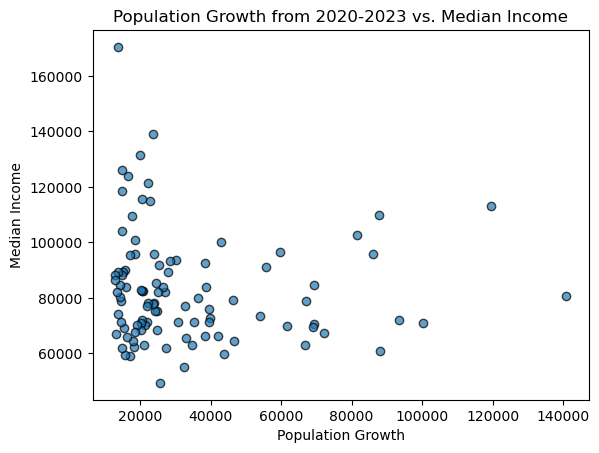

In [15]:
# Is there a correlation between population growth and median income?

x_value = pop_100median['Pop Growth from 2020-2023']
y_value = pop_100median['Median Income']
corr_coefficient = st.pearsonr(x_value, y_value)
print(f"The correlation between Population growth and Median Income is {round(corr_coefficient[0],2)}.")
plt.scatter(x_value, y_value, alpha=0.7, edgecolors='black')
plt.xlabel('Population Growth')
plt.ylabel('Median Income')
plt.title('Population Growth from 2020-2023 vs. Median Income')
plt.show()
# No.  there is no correlation between Population Growth and Median Income

In [16]:
#Plot of top 100 counties in Population Growth

pop100_mapplot=pop_100median.copy()
pop100_mapplot['Median Income']=pop100_mapplot['Median Income'].map("${:,.0f}".format)
pop100_mapplot['Pop Growth from 2020-2023']=pop100_mapplot['Pop Growth from 2020-2023'].map("{:,.0f}".format)
pop100_mapplot=pop100_mapplot[~pop100_mapplot['County'].str.contains('Montana')]
pop100_mapplot=pop100_mapplot[~pop100_mapplot['County'].str.contains('Arizona')]
pop100_mapplot=pop100_mapplot[~pop100_mapplot['County'].str.contains('Virginia')]
mapplot = pop100_mapplot.hvplot.points('Longitude', 'Latitude', geo=True, tiles='OSM', legend=False,
                                   frame_width= 700, frame_height=500, alpha = 0.5, color = 'purple', title = 'Top ~100 counties by Population Growth by Number',
                                   hover_cols=['Longitude', 'Latitude', 'County', 
                                               'Pop Growth from 2020-2023', 'Median Income'])
mapplot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (County,Pop Growth from 2020-2023,Median Income)

## -----------------------------------------------------------------------------------------------------------------------------
## Finding Counties with the Highest Population Growth %

In [17]:
pop_growth_percent['Pop Growth % from 2020-2023']=population_county_pd['2023']/population_county_pd['2020']*100-100

In [18]:
pop_growth_percent = pop_growth_percent.sort_values('Pop Growth % from 2020-2023', ascending=False)

pop_growth_percentmerge = pop_growth_percent.iloc[0:100].copy()
pop_growth_percentmerge = pop_growth_percentmerge[['County','2020','2023', 'Pop Growth % from 2020-2023']].set_index('County')


In [19]:
counties1 = []
lat1 = []
lon1 = []
for row in pop_growth_percentmerge.iterrows():
    counties1.append(row[0])
print(f'--------------------------------------------------')
print(f'Downloading Latitude and Longitude for each county')
for county in counties1:
    target_county = county
    target_url = f"https://api.geoapify.com/v1/geocode/search?text={target_county}&format=json&apiKey={geoapify_key}"
    resp = requests.get(target_url).json()
    lat1.append(resp["results"][0]["lat"])
    lon1.append(resp["results"][0]["lon"])
    print(f'Found Latitude and Longitude for {target_county}.')
    
print('Finished searching for Latitude and Longitudes')
print(f'--------------------------------------------------')

pop_growth_percentmerge['Latitude']=lat1
pop_growth_percentmerge['Longitude']=lon1


--------------------------------------------------
Found Latitude and Longitude for Kaufman County, Texas.
Found Latitude and Longitude for Long County, Georgia.
Found Latitude and Longitude for Rockwall County, Texas.
Found Latitude and Longitude for Comal County, Texas.
Found Latitude and Longitude for Dawson County, Georgia.
Found Latitude and Longitude for Custer County, Colorado.
Found Latitude and Longitude for Broadwater County, Montana.
Found Latitude and Longitude for Liberty County, Texas.
Found Latitude and Longitude for Sumter County, Florida.
Found Latitude and Longitude for Parker County, Texas.
Found Latitude and Longitude for Brunswick County, North Carolina.
Found Latitude and Longitude for St Johns County, Florida.
Found Latitude and Longitude for Jackson County, Georgia.
Found Latitude and Longitude for Jasper County, South Carolina.
Found Latitude and Longitude for Hays County, Texas.
Found Latitude and Longitude for Ellis County, Texas.
Found Latitude and Longitude

In [20]:
pop_growth_percentmerge.to_csv('Resources/Population%Top100.csv')

In [21]:
# Obtained Median Income for Top 100 Counties by Population Growth from: https://www.census.gov/quickfacts/

top100percent_median_df = pd.read_csv("Resources/Top100%Medianincome.csv")
top100percent_median_df.set_index('County')

,Median Income
County,
"Kaufman County, Texas",84075
"Long County, Georgia",56819
"Rockwall County, Texas",121303
"Comal County, Texas",93744
"Dawson County, Georgia",84516
...,...
"Gem County, Idaho",99999
"Bay County, Florida",99999
"Hood County, Texas",99999


In [22]:
top100percent_median = pop_growth_percentmerge.merge(top100percent_median_df, on='County')

top100percent_median = top100percent_median[['County', '2020', '2023','Pop Growth % from 2020-2023', 'Median Income', 'Latitude', 'Longitude']]
top100percent_median['Pop Growth from 2020-2023']=top100percent_median['2023']-top100percent_median['2020']
top100percent_median=top100percent_median[['County', 'Pop Growth % from 2020-2023',
                                           'Pop Growth from 2020-2023', 'Median Income', 'Latitude', 'Longitude']]
pop_100percentdisplay = top100percent_median.set_index('County').copy()
pop_100percentdisplay
pop_100percentdisplay.style.background_gradient(subset=['Median Income'], cmap=cm).background_gradient(subset=['Pop Growth from 2020-2023'], 
                                             cmap=cm2).background_gradient(subset=['Pop Growth % from 2020-2023'], 
                                             cmap=cm1).format({
    'Median Income':"${:,.0f}", 'Pop Growth % from 2020-2023':"{:,.2f}%", 'Pop Growth from 2020-2023':"{:,.0f}"})

,Pop Growth % from 2020-2023,Pop Growth from 2020-2023,Median Income,Latitude,Longitude
County,,,,,
"Kaufman County, Texas",26.20%,"38,550","$84,075",32.601641,-96.337513
"Long County, Georgia",20.43%,"3,324","$56,819",31.770490,-81.753725
"Rockwall County, Texas",20.29%,"22,149","$121,303",32.892346,-96.406699
"Comal County, Texas",18.50%,"30,269","$93,744",29.797970,-98.269079
"Dawson County, Georgia",17.27%,"4,673","$84,516",34.407708,-84.135677
"Custer County, Colorado",17.17%,811,"$66,250",38.107296,-105.354337
"Broadwater County, Montana",17.08%,"1,172","$61,679",43.408898,23.220319
"Liberty County, Texas",17.08%,"15,793","$59,605",30.085674,-94.785626
"Sumter County, Florida",16.33%,"21,275","$70,105",28.668975,-82.076402


In [23]:
#Plot of top 100 counties in Population Growth %

pop100perc_mapplot=top100percent_median.copy()
pop100perc_mapplot['Median Income']=pop100perc_mapplot['Median Income'].map("${:,.0f}".format)
pop100perc_mapplot['Pop Growth from 2020-2023']=pop100perc_mapplot['Pop Growth % from 2020-2023'].map("{:,.0f}%".format)
pop100perc_mapplot=pop100perc_mapplot[~pop100perc_mapplot['County'].str.contains('Montana')]
pop100perc_mapplot=pop100perc_mapplot[~pop100perc_mapplot['County'].str.contains('Arizona')]
pop100perc_mapplot=pop100perc_mapplot[~pop100perc_mapplot['County'].str.contains('Virginia')]
mapplot = pop100perc_mapplot.hvplot.points('Longitude', 'Latitude', geo=True, tiles='OSM', legend=False,
                                   frame_width= 700, frame_height=500, alpha = 0.5, color = 'blue', title = 'Top ~100 counties by Population Growth by %',
                                   hover_cols=['Longitude', 'Latitude', 'County', 
                                               'Pop Growth % from 2020-2023', 'Median Income'])
mapplot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (County,Pop Growth % from 2020-2023,Median Income)

## -----------------------------------------------------------------------------------------------------------------------------
## Merge Pop Growth by % and Pop Growth by Numbers

In [24]:
pop_merged = pop_100median.merge(top100percent_median, on=['County','Pop Growth from 2020-2023','Pop Growth % from 2020-2023', 
                                                           'Median Income', 'Latitude', 'Longitude'], how='outer')
pop_merged = pop_merged.drop_duplicates(subset=['County'])

pop_merged=pop_merged[['County','Pop Growth % from 2020-2023', 'Pop Growth from 2020-2023', 'Median Income', 'Latitude', 'Longitude']]
pop_merged_display = pop_merged.copy().set_index('County')
pop_merged_display = pop_merged_display.sort_values('Pop Growth % from 2020-2023', ascending=False)
pop_merged_display=pop_merged_display.style.background_gradient(subset=['Pop Growth from 2020-2023'], 
                                             cmap=cm2).background_gradient(subset=['Pop Growth % from 2020-2023'], 
                                             cmap=cm1).background_gradient(subset=['Median Income'], 
                                             cmap=cm).format({'Pop Growth % from 2020-2023':"{:,.2f}%", 
                                                               'Pop Growth from 2020-2023':"{:,.0f}",
                                                             'Median Income':"${:,.0f}"})
pop_merged_display

,Pop Growth % from 2020-2023,Pop Growth from 2020-2023,Median Income,Latitude,Longitude
County,,,,,
"Kaufman County, Texas",26.20%,"38,550","$84,075",32.601641,-96.337513
"Long County, Georgia",20.43%,"3,324","$56,819",31.770490,-81.753725
"Rockwall County, Texas",20.29%,"22,149","$121,303",32.892346,-96.406699
"Comal County, Texas",18.50%,"30,269","$93,744",29.797970,-98.269079
"Dawson County, Georgia",17.27%,"4,673","$84,516",34.407708,-84.135677
"Custer County, Colorado",17.17%,811,"$66,250",38.107296,-105.354337
"Broadwater County, Montana",17.08%,"1,172","$61,679",43.408898,23.220319
"Liberty County, Texas",17.08%,"15,793","$59,605",30.085674,-94.785626
"Sumter County, Florida",16.33%,"21,275","$70,105",28.668975,-82.076402


In [25]:
#Plot of top counties in Population Growth

pop_merged_mapplot=pop_merged.copy()
pop_merged_mapplot['Median Income']=pop_merged_mapplot['Median Income'].map("${:,.0f}".format)
pop_merged_mapplot['Pop Growth % from 2020-2023']=pop_merged_mapplot['Pop Growth % from 2020-2023'].map("{:,.2f}%".format)
pop_merged_mapplot['Pop Growth from 2020-2023']=pop_merged_mapplot['Pop Growth from 2020-2023'].map("{:,.0f}".format)

#Latitude and Longitude for counties in these states were incorrect, so removed them from mapplot
pop_merged_mapplot=pop_merged_mapplot[~pop_merged_mapplot['County'].str.contains('Montana')]
pop_merged_mapplot=pop_merged_mapplot[~pop_merged_mapplot['County'].str.contains('Arizona')]
pop_merged_mapplot=pop_merged_mapplot[~pop_merged_mapplot['County'].str.contains('Virginia')]

mapplot = pop_merged_mapplot.hvplot.points('Longitude', 'Latitude', geo=True, tiles='OSM', legend=False,
                                    frame_width= 700, frame_height=500, alpha = 0.5, color = 'County', title = 'Top ~200 counties by Population Growth by Number and %',
                                    hover_cols=['County','Longitude', 'Latitude', 'Median Income', 'Pop Growth from 2020-2023', 'Pop Growth % from 2020-2023', 'Median Income'])
mapplot

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (County,Median Income,Pop Growth from 2020-2023,Pop Growth % from 2020-2023,Median Income)

The correlation between Population Growth and Population Growth Percentage is -0.2.


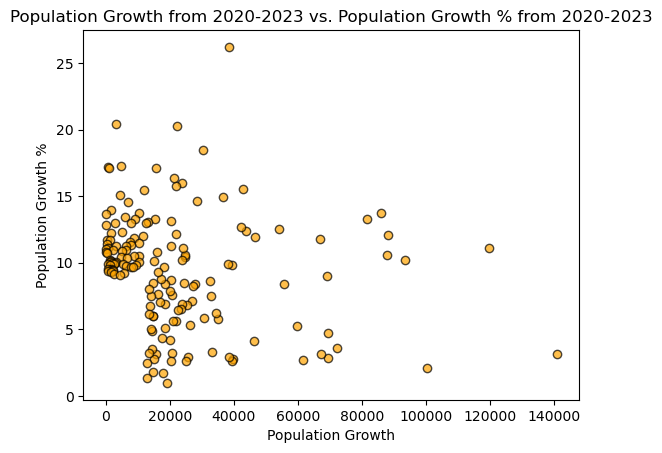

In [39]:
# Is there a correlation between population growth and population growth %?

x_value = pop_merged['Pop Growth from 2020-2023']
y_value = pop_merged['Pop Growth % from 2020-2023']
corr_coefficient = st.pearsonr(x_value, y_value)
print(f"The correlation between Population Growth and Population Growth Percentage is {round(corr_coefficient[0],2)}.")
plt.scatter(x_value, y_value, alpha=0.7, edgecolors='black', color='orange')
plt.xlabel('Population Growth')
plt.ylabel('Population Growth %')
plt.title('Population Growth from 2020-2023 vs. Population Growth % from 2020-2023')
plt.show()
# No.  there is no correlation between Population Growth and Population Growth %

## Median Housing Prices by County

In [40]:
medianhousing_df = pd.read_csv("Resources/median_housing_prices.csv")
medianhousing_df['2023 Median']=medianhousing_df['2023 Median'].astype(int)
medianhousing_df['2020 Median']=medianhousing_df['2020 Median'].astype(int)
medianhousing_df['Median Price Increase']=medianhousing_df['2023 Median']-medianhousing_df['2020 Median']
medianhousing_df['Median Price % Increase']=medianhousing_df['2023 Median']/medianhousing_df['2020 Median']*100-100
medianhousing_df=medianhousing_df[['County', 'Median Price Increase', 'Median Price % Increase']]

In [41]:
medianhousing_df=medianhousing_df.set_index('County')
medianhousing_df

,Median Price Increase,Median Price % Increase
County,,
"Blount County, Alabama",65000,34.210526
"Bullock County, Alabama",45000,31.034483
"Butler County, Alabama",45000,31.034483
"Calhoun County, Alabama",45000,31.034483
"Chambers County, Alabama",45000,31.034483
...,...,...
"Sweetwater County, Wyoming",24250,9.928352
"Teton County, Wyoming",160000,26.890756
"Uinta County, Wyoming",37000,18.974359


In [42]:
home_median = pop_merged.merge(medianhousing_df, on=['County'], how='left')
home_median = home_median.dropna()
home_median = home_median.sort_values('Median Price % Increase', ascending=False)
home_median = home_median[['County', 'Median Price % Increase','Median Price Increase','Pop Growth % from 2020-2023', 
                       'Pop Growth from 2020-2023', 'Median Income']]
home_median = home_median.set_index('County')
home_mediandisplay=home_median.copy()
home_mediandisplay=home_mediandisplay.style.background_gradient(subset=['Pop Growth from 2020-2023'], 
                                             cmap=cm2).background_gradient(subset=['Pop Growth % from 2020-2023'], 
                                             cmap=cm1).background_gradient(subset=['Median Income'], 
                                             cmap=cm).background_gradient(subset=['Median Price Increase'], 
                                             cmap=cm3).background_gradient(subset=['Median Price % Increase'], 
                                             cmap=cm4).format({'Pop Growth % from 2020-2023':"{:,.2f}%", 
                                                               'Pop Growth from 2020-2023':"{:,.0f}",
                                                             'Median Income':"${:,.0f}", 'Median Price Increase':"${:,.0f}",
                                                             'Median Price % Increase':"{:,.2f}%"})
home_mediandisplay

,Median Price % Increase,Median Price Increase,Pop Growth % from 2020-2023,Pop Growth from 2020-2023,Median Income
County,,,,,
"Gem County, Idaho",79.56%,"$144,000",9.33%,"1,799","$99,999"
"Boise County, Idaho",71.55%,"$171,000",11.13%,853,"$99,999"
"Canyon County, Idaho",71.55%,"$171,000",10.58%,"24,661","$68,473"
"Ada County, Idaho",69.81%,"$185,000",5.30%,"26,395","$83,881"
"Travis County, Texas",66.13%,"$205,000",2.96%,"38,348","$92,731"
"Tooele County, Utah",63.02%,"$170,100",11.85%,"8,696","$99,999"
"Bonner County, Idaho",61.71%,"$166,000",10.85%,"5,144","$99,999"
"Iron County, Utah",61.02%,"$144,000",11.26%,"6,498","$99,999"
"Hays County, Texas",60.38%,"$160,000",14.97%,"36,518","$79,990"


## -----------------------------------------------------------------------------------------------------------------------------